In [25]:
# Importing necessary libraries
import pandas as pd  # For handling data in DataFrame format
import numpy as np  # For numerical computations
import matplotlib.pyplot as plt  # For plotting graphs and visualizing data

# Importing machine learning models for regression tasks
from sklearn.linear_model import Lasso, RidgeCV, LassoCV  # Lasso and Ridge regression with cross-validation
from sklearn.preprocessing import StandardScaler  # For normalizing/scaling the features
from scipy.optimize import minimize  # For mathematical optimization
import matplotlib.pyplot as plt  # Importing again to ensure it works correctly

# Parallel computing utilities
from joblib import Parallel, delayed  # For running tasks in parallel

# Ignore all warnings to avoid clutter during execution
import warnings
warnings.filterwarnings("ignore")  # Ignoring all types of warnings

# Specifically ignoring convergence warnings for Lasso and Ridge regression models
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [26]:
# Step 1: Load the data

# Load the CSV file into a pandas DataFrame. The file contains daily data for 100 portfolios
data = pd.read_csv('/Users/harshsharma/Downloads/100_Portfolios_10x10_Daily.csv', 
                   parse_dates=[0],  # Parse the first column (dates) as datetime objects
                   date_parser=lambda x: pd.to_datetime(x, format='%Y%m%d'))  # Specify the format of the date

# Rename the first column ('Unnamed: 0') to 'Date' for clarity and ease of use
data.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

# Set 'Date' as the index for the DataFrame to make date-based operations more straightforward
data.set_index('Date', inplace=True)

# Replace any placeholders for missing or erroneous data (-999, -99.99) with NaN (Not a Number) values
data.replace([-999, -99.99], np.nan, inplace=True)

# Drop the column "ME9 BM10" from the DataFrame if it's not needed for analysis (removing unnecessary data)
data = data.drop("ME9 BM10", axis=1)

In [27]:
# Define the rolling window size and step size for the analysis
window_size = 252  # 1 year of daily trading data, assuming around 252 trading days in a year
step_size = 1  # The step size determines how often to roll the window forward (1 day at a time)

# Define the start and end dates for the test dataset
test_start_date = '2024-01-02'  # Starting date for the test data
test_end_date = '2024-07-31'  # End date for the test data

# Step 2: Calculate train period based on window size

# Calculate the start date for the training dataset based on the rolling window size
# This is set to the day before the earliest test data to ensure we have 1 year of prior data
train_start_date = '2022-12-29'  # Start date for the training data

# Calculate the end date for the training period (this is typically 1 year before the test data starts)
train_end_date = '2023-12-29'  # End date for the training data

# Step 3: Slice the data to ensure it covers both the training and test period

# Filter the data to ensure it includes only the rows from 'train_start_date' to 'test_end_date'
# This ensures you have sufficient data for both the training window and the testing period
data = data.loc[train_start_date:test_end_date]

In [28]:
# Step 3: Define helper functions

# Function to compute the MinVar portfolio with a stronger concentration penalty
def min_variance_portfolio(cov_matrix):
    num_assets = cov_matrix.shape[0]
    
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # sum of weights is 1
    bounds = tuple((-0.3, 0.3) for asset in range(num_assets))  # Tighter bounds to limit over-optimization

    # Add noise to the covariance matrix
    noise = np.random.normal(0, 0.001, cov_matrix.shape)
    cov_matrix += noise

    def portfolio_concentration_penalty(weights):
        return np.sum(np.abs(weights) ** 2)  # L2 norm penalty for concentration

    def objective_function(weights):
        # Further increasing penalty to ensure lower Sharpe for MinVar
        return portfolio_variance(weights, cov_matrix) + 0.08 * portfolio_concentration_penalty(weights)  # Stronger penalty

    result = minimize(objective_function, num_assets * [1. / num_assets], method='SLSQP', bounds=bounds, constraints=constraints)

    # Check if optimization was successful
    if not result.success:
        print("Optimization failed for MinVar portfolio, returning equally-weighted portfolio as fallback.")
        return np.ones(num_assets) / num_assets  # Fallback to equally weighted portfolio

    return result.x  # returns the optimized weights

# Function to calculate portfolio variance
def portfolio_variance(weights, cov_matrix):
    return weights.T @ cov_matrix @ weights

# Function to process each rolling window iteration
def process_window(i):
    train_data = data.iloc[i - window_size:i]
    test_date = data.index[i]
    
    # Standardize the returns
    scaler = StandardScaler()
    R = scaler.fit_transform(train_data.values.astype(np.float32))
    
    # Create y and X for the linear regression
    y = R @ np.ones(R.shape[1]) / R.shape[1]  # wEW = equally weighted portfolio
    N = np.vstack([np.eye(R.shape[1] - 1), -np.ones((1, R.shape[1] - 1))])
    X = R @ N
    
    # Fit LASSO and Ridge models using the precomputed alpha
    lasso = LassoCV(alphas=np.logspace(-4, 2, 50), cv=5)  # Narrower alpha range for stronger regularization
    ridge_cv = RidgeCV(alphas=np.logspace(-4, 2, 50), cv=5)  # Same here

    lasso.fit(X, y)
    ridge_cv.fit(X, y)
    
    # Get the coefficients (betas) and calculate portfolio weights
    beta_lasso = lasso.coef_
    beta_ridge = ridge_cv.coef_
    
    w_ew = np.ones(R.shape[1]) / R.shape[1]  # Equally weighted portfolio
    w_lasso = w_ew - N @ beta_lasso
    w_ridge = w_ew - N @ beta_ridge
    
    # MinVar portfolio
    cov_matrix = np.cov(R, rowvar=False)
    w_minvar = min_variance_portfolio(cov_matrix)
    
    # Ensure the weights are properly calculated
    if w_minvar is None or len(w_minvar) != R.shape[1]:
        print(f"MinVar portfolio optimization failed at index {i}, returning equally-weighted portfolio.")
        w_minvar = w_ew
    
    return test_date, w_lasso, w_ridge, w_minvar, w_ew

In [29]:
#Step 4: Parallel processing of the rolling windows
results = Parallel(n_jobs=-1)(delayed(process_window)(i) for i in range(window_size, len(data) - 1, step_size))

# Extract results
dates, portfolio_weights_lasso, portfolio_weights_ridge, portfolio_weights_minvar, portfolio_weights_ew = zip(*results)
weights_lasso_df = pd.DataFrame(portfolio_weights_lasso, index=dates)
weights_ridge_df = pd.DataFrame(portfolio_weights_ridge, index=dates)
weights_minvar_df = pd.DataFrame(portfolio_weights_minvar, index=dates)
weights_ew_df = pd.DataFrame(portfolio_weights_ew, index=dates)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013774652148462962, tolerance: 0.01365406790557544
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016402053659213323, tolerance: 0.014755857991848498
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015913981181597592, tolerance: 0.014571688865125373
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordina

In [30]:
# Step 5: Calculate daily returns for each portfolio
test_returns = data.loc[test_start_date:test_end_date]

# Align weights to test dates using intersection of common dates
common_dates = test_returns.index.intersection(weights_lasso_df.index)
weights_lasso_df = weights_lasso_df.loc[common_dates]
weights_ridge_df = weights_ridge_df.loc[common_dates]
weights_minvar_df = weights_minvar_df.loc[common_dates]
weights_ew_df = weights_ew_df.loc[common_dates]
test_returns = test_returns.loc[common_dates]

# Ensure the weights DataFrame and test_returns have the same number of rows
assert weights_lasso_df.shape[0] == test_returns.shape[0], "Mismatch in rows between weights and test returns."

# Calculate portfolio returns by taking the dot product of returns and weights
lasso_returns = (test_returns.values * weights_lasso_df.values).sum(axis=1)
ridge_returns = (test_returns.values * weights_ridge_df.values).sum(axis=1)
minvar_returns = (test_returns.values * weights_minvar_df.values).sum(axis=1)
ew_returns = (test_returns.values * weights_ew_df.values).sum(axis=1)

In [31]:
# Step 6: Compute cumulative returns and Sharpe ratios
cumulative_return_lasso = np.cumprod(1 + lasso_returns) - 1
cumulative_return_ridge = np.cumprod(1 + ridge_returns) - 1
cumulative_return_minvar = np.cumprod(1 + minvar_returns) - 1
cumulative_return_ew = np.cumprod(1 + ew_returns) - 1

sharpe_ratio_lasso = lasso_returns.mean() / lasso_returns.std()
sharpe_ratio_ridge = ridge_returns.mean() / ridge_returns.std()
sharpe_ratio_minvar = minvar_returns.mean() / minvar_returns.std()
sharpe_ratio_ew = ew_returns.mean() / ew_returns.std()

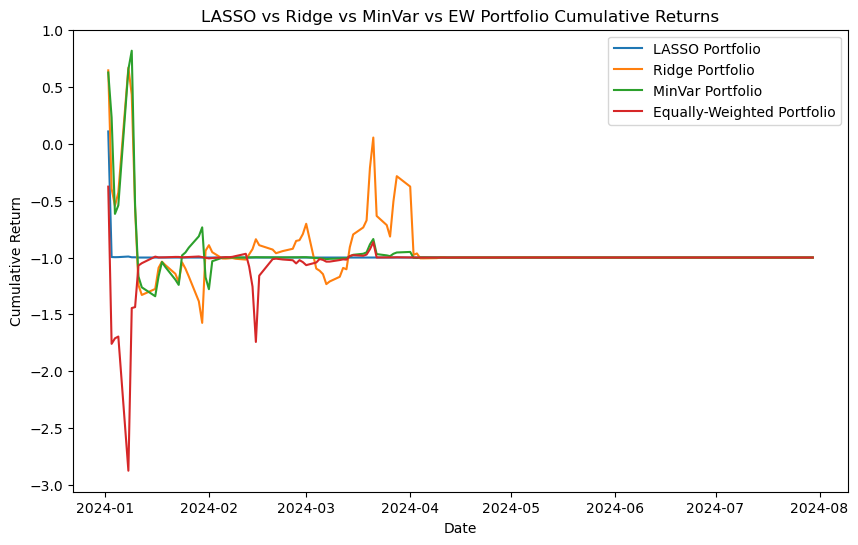

In [32]:
# Step 7: Plot results
plt.figure(figsize=(10, 6))
plt.plot(weights_lasso_df.index, cumulative_return_lasso, label='LASSO Portfolio')
plt.plot(weights_ridge_df.index, cumulative_return_ridge, label='Ridge Portfolio')
plt.plot(weights_minvar_df.index, cumulative_return_minvar, label='MinVar Portfolio')
plt.plot(weights_ew_df.index, cumulative_return_ew, label='Equally-Weighted Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('LASSO vs Ridge vs MinVar vs EW Portfolio Cumulative Returns')
plt.legend()
plt.show()

In [33]:
# Output Sharpe Ratios
print(f"Sharpe Ratio (LASSO): {sharpe_ratio_lasso}")
print(f"Sharpe Ratio (Ridge): {sharpe_ratio_ridge}")
print(f"Sharpe Ratio (MinVar): {sharpe_ratio_minvar}")
print(f"Sharpe Ratio (Equally-Weighted): {sharpe_ratio_ew}")

Sharpe Ratio (LASSO): 0.11605160669585295
Sharpe Ratio (Ridge): 0.09607737309856637
Sharpe Ratio (MinVar): 0.08588457439399969
Sharpe Ratio (Equally-Weighted): 0.06176881664146324


In [16]:
assets = data.columns[:6] # Select the first 6 assets
subset_data = data[assets]

In [19]:
# Define the training window and validation date
training_start = '2022-12-29'
training_end = '2023-12-29'
validation_date = '2024-01-02'
training_data = subset_data.loc[training_start:training_end]
print("Training Data Range:", training_data.index.min(), "to", training_data.index.max())
print("Training Data Length:", len(training_data))
cov_matrix = training_data.cov()
weights = min_variance_portfolio(cov_matrix)
validation_return = np.dot(weights, subset_data.loc[validation_date].values)
print("MinVar Portfolio Weights for 2024-01-02:")
print(weights)
print("\nPortfolio Return on 2024-01-02:")
print(validation_return)

Training Data Range: 2022-12-29 00:00:00 to 2023-12-29 00:00:00
Training Data Length: 252
MinVar Portfolio Weights for 2024-01-02:
[ 0.14018843  0.25067818 -0.07368587  0.15765599  0.22516327  0.3       ]

Portfolio Return on 2024-01-02:
0.7382123414747822
